In [1]:
# Author： 施源 Kris
# Create Time： 2018.8.15

import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get Stock Data

In [1]:
# 用quandl的api获取stock price 以苹果公司股票进行实验 代码-APPL
import quandl  
quandl.ApiConfig.api_key = "gG8vr-_3fVigtYzrQf5B"

In [3]:
# stock_data = quandl.get_table('WIKI/PRICES', qopts = {'columns': ['date', 'open', 'high', 'low', 'close', 'volume'] }, ticker = ['AAPL'], date = { 'gte': '2010-01-01', 'lte': '2017-12-31' })
stock_data = quandl.Dataset('WIKI/AAPL').data()
# 转换为pandas形式
df = stock_data.to_pandas()

In [5]:
# 过老的数据没有太大的参考价值，取最近几年的数据
_df = df[8000:]

In [395]:
_df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-08-29,675.25,677.670,672.600,673.466,7243100.0,0.0,1.0,87.149511,87.461842,86.807495,86.919263,50701700.0
2012-08-30,670.64,671.554,662.853,663.868,10810700.0,0.0,1.0,86.554532,86.672495,85.549522,85.680520,75674900.0
2012-08-31,667.25,668.600,657.250,665.240,12082900.0,0.0,1.0,86.117010,86.291244,84.826384,85.857594,84580300.0
2012-09-04,665.76,675.140,664.500,674.970,13139000.0,0.0,1.0,85.924707,87.135314,85.762088,87.113373,91973000.0
2012-09-05,675.57,676.350,669.600,670.230,12013400.0,0.0,1.0,87.190811,87.291479,86.420307,86.501616,84093800.0


## Preprocess Data

In [399]:
data = _df
print(data.index.min(), data.index.max())
data.head()

2012-08-29 00:00:00 2018-03-27 00:00:00


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-08-29,675.25,677.670,672.600,673.466,7243100.0,0.0,1.0,87.149511,87.461842,86.807495,86.919263,50701700.0
2012-08-30,670.64,671.554,662.853,663.868,10810700.0,0.0,1.0,86.554532,86.672495,85.549522,85.680520,75674900.0
2012-08-31,667.25,668.600,657.250,665.240,12082900.0,0.0,1.0,86.117010,86.291244,84.826384,85.857594,84580300.0
2012-09-04,665.76,675.140,664.500,674.970,13139000.0,0.0,1.0,85.924707,87.135314,85.762088,87.113373,91973000.0
2012-09-05,675.57,676.350,669.600,670.230,12013400.0,0.0,1.0,87.190811,87.291479,86.420307,86.501616,84093800.0


## Split Train & Test Data

In [405]:
# Unmodified 
date_split = '2016-01-01'
train = data[:date_split]
test = data[date_split:]
len(train), len(test)

(840, 560)

In [406]:
_train = train
_test = test

In [407]:
# 获取当天交易价格数据
_train_c_open = _train[['Open']]
_train_c_open[1:].head()

,Open
Date,
2012-08-30,670.64
2012-08-31,667.25
2012-09-04,665.76
2012-09-05,675.57
2012-09-06,673.17


In [408]:
tradePrice = np.array(_train_c_open[1:])

In [409]:
_train = _train[:-1]

In [410]:
len(tradePrice) == len(_train)

True

In [411]:
# 获取历史股价数据
_train = _train.loc[:,['Open','High','Low','Close','Volume']] 
_train['tradePrice'] = tradePrice
_train['cash'] = 100000.
_train['stockValue'] = 0.

_train = np.array(_train)

In [412]:
_train.shape

(839, 8)

In [413]:
# 获取当天交易价格数据
_test_c_open = _test[['Open']]
_test_c_open[1:].head()

,Open
Date,
2016-01-05,105.75
2016-01-06,100.56
2016-01-07,98.68
2016-01-08,98.55
2016-01-11,98.97


In [414]:
tradePrice = np.array(_test_c_open[1:])

In [415]:
_test = _test[:-1]

In [416]:
len(tradePrice) == len(_test)

True

In [417]:
# 获取历史股价数据
_test = _test.loc[:,['Open','High','Low','Close','Volume']] 
_test['tradePrice'] = tradePrice
_test['cash'] = 100000.
_test['stockValue'] = 0.

_test = np.array(_test)

In [418]:
_test.shape

(559, 8)

## Set Global Parameter

In [421]:
N_FEATURES = 8   # 每个sample的feature数量（open、high、low、close、volumn、tradePrice、cash、stockValue）

N_TIMESTEPS = 20 # 每个sample的步长 timstep 20

EPSILON = 0.95   # 贪婪度 greedy

LEARNING_RATE = 0.001     # 学习率

GAMMA = 0.95    # 奖励递减值,discount

EPOCHS = 5000   # 回合数

BATCH_SIZE = 64

ORDER_SIZE = 500 # 每次下单交易股数

REPLACE_TARGET_ITER = 200  # 更换 target_net 的步数


## Build Environment

- 用历史（过去20天）的stock price、当天的cash、stockValue、open price作为观察量；用第21天的open price作为交易价格；执行交易后更新第21天的cash、stockValue
- 现金小于0或股票数小于0（不允许做空），给予最大惩罚，提前结束本次训练

In [505]:
from tensorforce.environments import Environment

class StockEnv(Environment):
    
    def __init__(self, data):
        
        # 获取股价数据，包括过去20天的历史数据和当天的开盘价
        self.xdata = data
        self.sample_size = len(self.xdata)
        self.reset()
        
        
    def __str__(self):
        return 'StockEnvironment'

    def close(self):
        """
        Close environment. No other method calls possible afterwards.
        """
        print('game over')

    def seed(self, seed):
        """
        Sets the random seed of the environment to the given value (current time, if seed=None).
        Naturally deterministic Environments (e.g. ALE or some gym Envs) don't have to implement this method.
        Args:
            seed (int): The seed to use for initializing the pseudo-random number generator (default=epoch time in sec).
        Returns: The actual seed (int) used OR None if Environment did not override this method (no seeding supported).
        """
        return None

    def reset(self):
        """
        Reset environment and setup for new episode.
        Returns:
            initial state of reset environment.
        """
        # 训练次数初始化
        self.step_counter = 0  
        # 奖励初始化
        self.reward = 0 
        # 状态初始化
#         self.current_state = self.states 
        self.next_states = self.xdata[self.step_counter + 1:self.step_counter + N_TIMESTEPS + 1]
        
        # 获取交易当天的开盘价 20+1
        self.tradePrice = self.states[-1, 5]
        self.cal_value_price = self.states[-1, 3]
        
        # 当前股票
        self.stock_amount = 0 # 持有股票数量初始化
        self.stock_value = 0 # 股票价值初始化

        # 当前现金
        self.cash_hold = 100000. # 持有现金初始化
        
        # 当前财富总值初始化 （当前现金+股票价值）
        self.current_value = self.cash_hold + self.stock_value 
        
        # 过去财富总值初始化
        self.past_value = 100000. 
        
        self.done = False # 当前是否为结束状态
        

    def execute(self, action):
        """
        Executes action, observes next state(s) and reward.
        Args:
            actions: Actions to execute.
        Returns:
            Tuple of (next state, bool indicating terminal, reward)
        """
        # 更新past_value为当前财富总值
        self.past_value = self.current_value
        
        # 用于计算的价格
        self.cal_value_price = self.states[-1, 3]
        self.tradePrice = self.states[-1, 5]
        
        if action == 1: #'buy'
            # cash
            self.cash_hold = self.cash_hold - self.tradePrice * ORDER_SIZE
            # stock
            self.stock_amount = self.stock_amount + ORDER_SIZE
        elif action == 2: #'sell'
            # cash
            self.cash_hold = self.cash_hold + self.tradePrice * ORDER_SIZE
            # stock
            self.stock_amount = self.stock_amount - ORDER_SIZE   

        # 更新state状态
        if self.step_counter + N_TIMESTEPS + 1 < self.sample_size:
            self.done = False
            self.next_states = self.xdata[self.step_counter + 1 : self.step_counter + N_TIMESTEPS + 1]
            self.xdata[self.step_counter + N_TIMESTEPS, 6] = self.cash_hold
            self.xdata[self.step_counter + N_TIMESTEPS, 7] = self.next_states[-1, 3] * self.stock_amount  
        else:
            self.done = True
            self.next_states = self.states
            self.xdata[self.step_counter + N_TIMESTEPS, 6] = self.cash_hold
            self.xdata[self.step_counter + N_TIMESTEPS, 7] = self.next_states[-1, 0] * self.stock_amount
            self.step_counter = 0
        
        self.current_value = self.states[-1,6] + self.states[-1,7]

        # 现金数量或者股票数量小于0，给予最大惩罚，提前结束本轮
        if self.cash_hold <= 0 or self.stock_amount < 0:
            self.reward = self.reward - 10000
            self.done = True
        # 否则继续
        else:
            self.done = False
            # 更新reward
            self.reward = self.reward + (self.current_value - self.past_value) 

        self.step_counter = self.step_counter + 1
        
        return self.next_states, self.done, self.reward 
    
    
    @property
    def states(self):
        """
        Return the state space. Might include subdicts if multiple states are 
        available simultaneously.
        Returns:
            States specification, with the following attributes
                (required):
                - type: one of 'bool', 'int', 'float' (default: 'float').
                - shape: integer, or list/tuple of integers (required).
        """
        if self.step_counter + N_TIMESTEPS <= N_SAMPLES:
            states = self.xdata[self.step_counter : self.step_counter + N_TIMESTEPS]
            return states
        else:
            print("No More Data.")
            self.done = True
            return self.xdata[self.step_counter-1 : self.step_counter + N_TIMESTEPS-1]

    @property
    def actions(self):
        """
        Return the action space. Might include subdicts if multiple actions are 
        available simultaneously.
        Returns:
            actions (spec, or dict of specs): Actions specification, with the following attributes
                (required):
                - type: one of 'bool', 'int', 'float' (required).
                - shape: integer, or list/tuple of integers (default: []).
                - num_actions: integer (required if type == 'int').
                - min_value and max_value: float (optional if type == 'float', default: none).
        """
        actions = [0, 1, 2] # 0: 'hold', 1: 'buy', 2: 'sell']
        
        return actions


    @staticmethod
    def from_spec(spec, kwargs):
        """
        Creates an environment from a specification dict.
        """
        env = tensorforce.util.get_object(
            obj=spec,
            predefined_objects=tensorforce.environments.environments,
            kwargs=kwargs
        )
        assert isinstance(env, Environment)
        return env

## Build DQN Model

In [459]:
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate = 0.001,
            reward_decay = 0.95,
            e_greedy = 0.95,
            replace_target_iter = 200,
            memory_size = 2000,
            batch_size = 64,
            e_greedy_increment = None,
            output_graph = False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy     # epsilon 的最大值
        self.replace_target_iter = replace_target_iter  # 更换 target_net 的步数
        self.memory_size = memory_size  # 记忆上限
        self.batch_size = batch_size    # 每次更新时从 memory 里面取多少记忆出来
        self.epsilon_increment = e_greedy_increment # epsilon 的增量
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max # 是否开启探索模式, 并逐步减少探索次数

        # 记录学习次数 (用于判断是否更换 target_net 参数)
        self.learn_step_counter = 0
        
        # 记录cost
        self.cost_his = list()

        # 初始化全 0 记忆 [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, 20 * n_features * 2 + 2)) # 和视频中不同, 因为 pandas 运算比较慢, 这里改为直接用 numpy

        # 创建 [target_net, evaluate_net]
        self.create_network()

        # 替换 target net 的参数
        t_params = tf.get_collection('target_net_params')  # 提取 target_net 的参数
        e_params = tf.get_collection('eval_net_params')   # 提取  eval_net 的参数
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)] # 更新 target_net 参数

        with tf.variable_scope('soft_replacement'):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]


        self.sess = tf.Session()
          
        # 输出 tensorboard 文件
        if output_graph:
            # $ tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)
        
        self.sess.run(tf.global_variables_initializer())
        
        # saving and loading networks
        self.saver = tf.train.Saver()
        
        checkpoint = tf.train.get_checkpoint_state("saved_networks")
        if checkpoint and checkpoint.model_checkpoint_path:
            self.saver.restore(self.sess, checkpoint.model_checkpoint_path)
            print("Successfully loaded:", checkpoint.model_checkpoint_path)
        else:
            print("Could not find old network weights")

    def create_network(self):
        tf.reset_default_graph()
        
        # ------------------ all inputs ------------------------
        self.s = tf.placeholder(tf.float64, [None, 20 * self.n_features], name='s')  # input State
        self.s_ = tf.placeholder(tf.float64, [None, 20 * self.n_features], name='s_')  # input Next State
        self.r = tf.placeholder(tf.float64, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action

        w_initializer, b_initializer = tf.random_normal_initializer(mean = 0., stddev = 0.3, dtype = tf.float64), tf.constant_initializer(0.1)
  
        # ------------------ build evaluate_net ------------------
        with tf.variable_scope('eval_net'):
            e1 = tf.layers.dense(self.s, 128, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='e1')
            e2 = tf.layers.dense(e1, 128, tf.nn.relu, name='e2')
            self.q_eval = tf.layers.dense(e2, self.n_actions, tf.nn.softmax, name='q')

        # ------------------ build target_net ------------------
        with tf.variable_scope('target_net'):
            t1 = tf.layers.dense(self.s_, 128, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='t1')
            t2 = tf.layers.dense(t1, 128, tf.nn.relu, name='t2')
            self.q_next = tf.layers.dense(t2, self.n_actions, tf.nn.softmax, name='q_')

        with tf.variable_scope('q_target'):
            q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    # shape=(None, )
            self.q_target = tf.stop_gradient(q_target)
        with tf.variable_scope('q_eval'):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)  
            self.q_eval_wrt_a = tf.gather_nd(params = self.q_eval, indices = a_indices)    # shape=(None, )
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s.reshape(-1), [a, r], s_.reshape(-1)))
        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]
        observation = observation.reshape(-1,160)
        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value) % self.n_actions
        else:
            action = np.random.randint(0, self.n_actions)

        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]
        
        
        _, cost = self.sess.run(
            [self._train_op, self.loss],
            feed_dict={
                self.s: batch_memory[:, : 20 * self.n_features],
                self.a: batch_memory[:, 20 * self.n_features],
                self.r: batch_memory[:, 20 * self.n_features + 1],
                self.s_: batch_memory[:,-20 * self.n_features:],
            })
        self.cost_his.append(cost)

        if self.learn_step_counter % 1000 == 0:
            self.saver.save(self.sess, 'saved_networks/' + 'TRADER' + '-dqn', global_step = self.learn_step_counter)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

if __name__ == '__main__':
    DQN = DeepQNetwork(3, 8)

INFO:tensorflow:Restoring parameters from saved_networks/TRADER-dqn-68000
Successfully loaded: saved_networks/TRADER-dqn-68000


## Help Method

In [424]:
import matplotlib.pyplot as plt

# 画图查看结果
def plot_fortune(fortune):
    plt.plot(np.arange(len(fortune)), fortune)
    plt.ylabel('Fortune')
    plt.xlabel('Training steps')
    plt.show()

## Build Runner

In [460]:
# 用于训练的Runner

# 设置训练环境
env = StockEnv(_train)
# 初始化训练网络
network = DeepQNetwork(len(env.actions), env.states.shape[1],
                      learning_rate = LEARNING_RATE,
                      reward_decay = GAMMA,
                      e_greedy = EPSILON,
                      replace_target_iter = 200,  # 每 200 步替换一次 target_net 的参数
                      memory_size = 2000, # 记忆上限
                      # output_graph=True   # 是否输出 tensorboard 文件
                      )


def trainer(env, network):
    env = env
    DQN = network
    step = 0    # 用来控制什么时候学习

    # 用于记录所有epochs的最终训练结果
    fortune = list()
    
    for episode in range(3000):
        # 初始化环境
        env.reset()
        c_state = env.states

        # 初始化当前episode的动作列表 
        act = list()
        total = list()
        while True:
            # DQN 根据观测值选择行为
            action = DQN.choose_action(c_state)
            
            # 记录当前action
            act.append(action)
            
            # 环境根据行为给出下一个 state, reward, 是否终止
            n_state, done, reward = env.execute(action)
            
            # 记录当前财富总值
            total.append(n_state[-1,6] + n_state[-1,7])
            
            # DQN 存储记忆
            DQN.store_transition(c_state, action, reward, n_state)

            # 控制学习起始时间和频率 (先累积一些记忆再开始学习)
            if (step > 200):
                DQN.learn()

            # 将下一个 state_ 变为 下次循环的 state
            c_state = n_state

            # 如果终止, 就跳出循环
            if done:
                break
            step += 1   # 总步数
            
           
        if episode % 500 == 0:
            # 画出此次episode的财富价值曲线
            print("Episode" + str(episode) + " : ")
            plot_fortune(total)
            print("Actions :")
            print(act)

        fortune.append(total[-1])
        
    print(fortune)
    # 画图查看所有轮次的fortune分布情况
    plt.hist(fortune)    
    # 结束
    env.close()
    return DQN, fortune
    

INFO:tensorflow:Restoring parameters from saved_networks/TRADER-dqn-68000
Successfully loaded: saved_networks/TRADER-dqn-68000


Episode0 : 


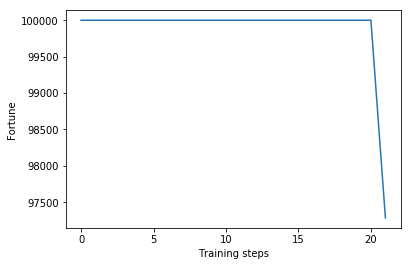

Actions :
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced

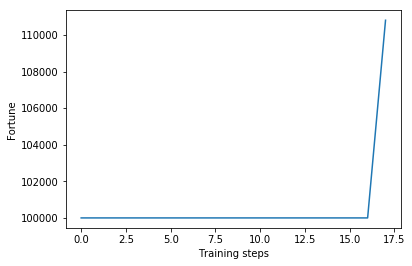

Actions :
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_pa

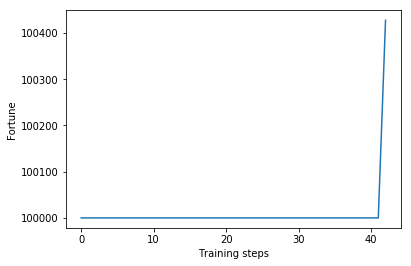

Actions :
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_pa

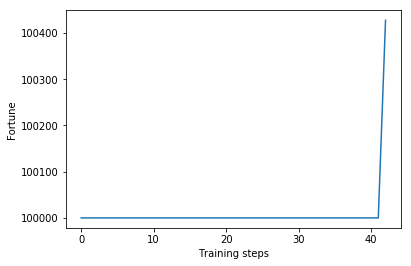

Actions :
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_pa

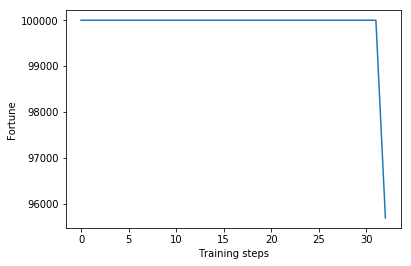

Actions :
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_

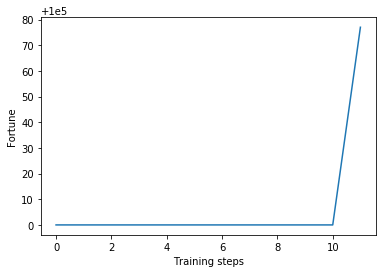

Actions :
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


ta

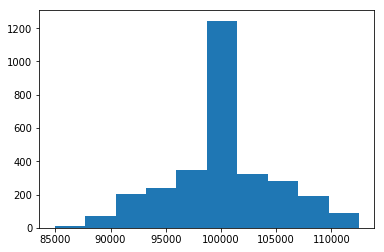

In [461]:
# 执行训练
Q, f = trainer(env, network)

In [469]:
print("平均最终财富值：")
print(np.mean(f))

平均最终财富值：
100204.79504999999


In [486]:
_test.shape

(559, 8)

In [509]:
_t = _test[-100:]

In [510]:
_t.shape

(100, 8)

In [513]:
# 用于测试的Runner

# 设置测试环境
e = StockEnv(_t) 
# 使用之前训练好的DQN网络
n = Q 

def tester(env, network):
    env = env
    DQN = network
        # 用来控制什么时候学习
#     action_list = list() # [[0,1,0...],[1,2,0...],[0,0,1...],[2,1,1...],[2,1,2...]]

    # 用于记录所有epochs的最终训练结果
    fortune = list()
    
    for episode in range(5000):
        # 初始化环境
        env.reset()
        c_state = env.states

        # 用来控制什么时候学习
        step = 0
        # 初始化当前episode的动作列表 
        act = list()
        total = list()
        while True:
            # DQN 根据观测值选择行为
            action = DQN.choose_action(c_state)
            # 记录当前action
            act.append(action)
            
            # 环境根据行为给出下一个 state, reward, 是否终止
            n_state, done, reward = env.execute(action)
            # 记录当前财富总值
            total.append(n_state[-1,6] + n_state[-1,7])
            
            # DQN 存储记忆
#             DQN.store_transition(c_state, action, reward, n_state)

            # 控制学习起始时间和频率 (先累积一些记忆再开始学习)
#             if (step > 200) and (step % 5 == 0):
#                 DQN.learn()

            # 将下一个 state_ 变为 下次循环的 state
            c_state = n_state

            # 如果终止, 就跳出循环
            if done:
                break
            step += 1   # 总步数
            
        # 由于做空被提前结束的结果不采用
#         print(len(total))
#         print(len(_test))
        if len(total) == 80:
            plot_fortune(total)
            print("Acts:")
            print(act)
            print("Period Fortune:")
            print(total)
            fortune.append(total[-1])
            break
    # 输出最终财富总值
    print("Final Fortune:")
    print(fortune)

    
    env.close()


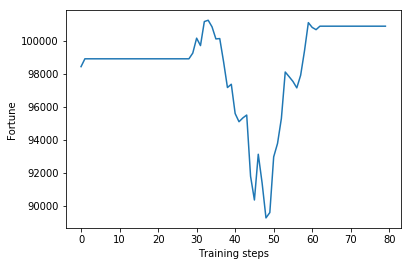

Acts:
[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
Period Fortune:
[98425.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 98900.0, 99245.0, 100150.0, 99700.0, 101155.0, 101235.0, 100835.0, 100105.0, 100125.0, 98715.0, 97160.0, 97360.0, 95585.0, 95090.0, 95320.0, 95495.0, 91790.0, 90350.0, 93120.0, 91375.0, 89265.0, 89590.0, 92960.0, 93775.0, 95290.0, 98100.0, 97820.0, 97530.0, 97140.0, 97905.0, 99382.5, 101090.0, 100800.0, 100665.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0, 100875.0,

In [514]:
tester(e,n)